# Project Overview

Our client is looking to promote Ed Sheeran’s new album - and want to be both targeted with their customer communications, and as efficient as possible with their marketing budget.

As a proof-of-concept they would like us to build a classification model for customers who purchased Ed’s last album based upon a small sample of listening data they have acquired for some of their customers at that time.

If we can do this successfully, they will look to purchase up-to-date listening data, apply the model, and use the predicted probabilities to promote to customers who are most likely to purchase.

The sample data is short but wide. It contains only 356 customers, but for each, columns that represent the percentage of historical listening time allocated to each of 100 artists. On top of these, the 100 columns do not contain the artist in question, instead being labelled artist1, artist2 etc.

We will need to compress this data into something more manageable for classification!



In [38]:
# pca is a technique often used for dimensionality reduction that will reduce large
# number of input variables into a smaller ones each known as principal component
# that will contain most of the information

import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA


In [39]:
data_for_model = pd.read_csv(r"/Users/praju/Desktop/DSI/Untitled Folder/PCA/sample_data_pca.csv")

In [40]:
data_for_model.head()

,user_id,purchased_album,artist1,artist2,artist3,artist4,artist5,artist6,artist7,artist8,...,artist91,artist92,artist93,artist94,artist95,artist96,artist97,artist98,artist99,artist100
0,1,1,0.0000,0.0891,0.0,0.0,0.0,0.0000,0.0,0.0,...,0.0000,0.0001,0.0606,0.0,0.0000,0.0578,0.1554,0.0001,0.0000,0.0000
1,2,0,0.0000,0.0000,0.0,0.0,0.0,0.0001,0.0,0.0,...,0.0008,0.0000,0.0016,0.0,0.0000,0.0000,0.0030,0.0034,0.8695,0.0037
2,3,1,0.0002,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,...,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.7179,0.0000,0.0008
3,4,1,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,...,0.0146,0.0275,0.0060,0.0,0.1724,0.0000,0.0021,0.0012,0.0000,0.0000
4,5,1,0.0006,0.0000,0.0,0.0,0.0,0.0002,0.0,0.0,...,0.0310,0.1061,0.0000,0.0,0.0010,0.0000,0.6773,0.0000,0.0000,0.0000


The data is at customer level. We have a binary column aka **purchased_album** showing whether the customer purchased the prior album or not, and following that remaining 100 columns containing the percentage of historical listening time allocated to each artist. We do not know the names of these artists.

From the above sample, we can also see the sparsity of the data, customers do not listen to all artists and therefore many of the values are 0.

In [41]:
data_for_model.shape

(356, 102)

In [42]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Columns: 102 entries, user_id to artist100
dtypes: float64(100), int64(2)
memory usage: 283.8 KB


In [43]:
data_for_model.drop('user_id',axis=1,inplace=True)

In [44]:
# Shuffle Data

# if there are unknown order in data i.e sorted by customer number i.e sorted in longer term customer 
# to newer customers, this may or may not have the impact on the model and easy way to make sure it does'nt is to 
# always shuffle our data

data_for_model = shuffle(data_for_model, random_state=42)

In [45]:
data_for_model['purchased_album'].value_counts(normalize=True)
# we can see we have a quite balance here in the dataset

1    0.533708
0    0.466292
Name: purchased_album, dtype: float64

In [46]:
data_for_model.isna().sum()

purchased_album    0
artist1            0
artist2            0
artist3            0
artist4            0
                  ..
artist96           0
artist97           0
artist98           0
artist99           0
artist100          0
Length: 101, dtype: int64

In [47]:
data_for_model.isna().sum().sum() # gives total number of missing rows 
# as we can't see clearly for all the columns

0

In [48]:
data_for_model.describe()

,purchased_album,artist1,artist2,artist3,artist4,artist5,artist6,artist7,artist8,artist9,...,artist91,artist92,artist93,artist94,artist95,artist96,artist97,artist98,artist99,artist100
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,...,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,0.533708,0.002399,0.001245,0.000427,0.000704,0.002856,0.000867,0.000261,0.004274,0.000253,...,0.017004,0.046888,0.062277,0.070886,0.050739,0.045152,0.049222,0.042250,0.066055,0.022312
std,0.499565,0.012821,0.009374,0.003015,0.004589,0.027863,0.008944,0.003464,0.024472,0.001778,...,0.084572,0.147033,0.186326,0.178980,0.165047,0.149428,0.160892,0.146979,0.192017,0.092230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000400,0.003650,0.003525,0.008700,0.000925,0.001000,0.002825,0.003150,0.003725,0.000700
max,1.000000,0.142700,0.110400,0.036700,0.055500,0.371600,0.129200,0.054200,0.260700,0.020200,...,0.915800,0.930200,0.933400,0.941800,0.880300,0.901800,0.935700,0.935600,0.967300,0.854300


In [49]:
# splitting input & output variable

X = data_for_model.drop('purchased_album',axis=1)
y = data_for_model['purchased_album']

In [50]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
# stratify = means our train and test set should have same proportions of classes as overall data

In [51]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(284, 100)
(72, 100)
(284,)
(72,)


In [52]:
# Feature Scaling 

# As we discussed in the tutorial, scaling is vital in PCA, It means that the algorithms can successfully judge
# the correlations between the variables and effectively create the principal components for us
# so here we going to use "Standardisation"

scale_standard = StandardScaler()
X_train = scale_standard.fit_transform(X_train) 
X_test = scale_standard.transform(X_test) # we use "transform" because we want to apply the rules to test data

In [53]:
# Apply PCA

pca = PCA(n_components=None, random_state=42) # we can set the components as "values"/"proportions"
# it would create required number of components to explain the specified percentage of variance

In [54]:
pca.fit(X_train) # it has fitted the data.
# we are not gonna use "transform" as we just want to check the variance that have at each number of components
# so we then get an idea of what number of components we may want to choose

PCA(random_state=42)

There is no right or wrong number of components to use - this is something that we need to decide based upon the scenario we’re working in. We know we want to reduce the number of features, but we need to trade this off with the amount of information we lose.

In the following below code, we extract this information from the prior step where we fit the PCA object to our training data. We extract the variance for each component, and we do the same again, but for the cumulative variance. Will will assess & plot both of these in the next step.

In [55]:
# Extract the explained variance across components
explained_variance = pca.explained_variance_ratio_
explained_variance_cumulative = pca.explained_variance_ratio_.cumsum()

In [56]:
explained_variance.shape

(100,)

In [57]:
explained_variance_cumulative.shape

(100,)

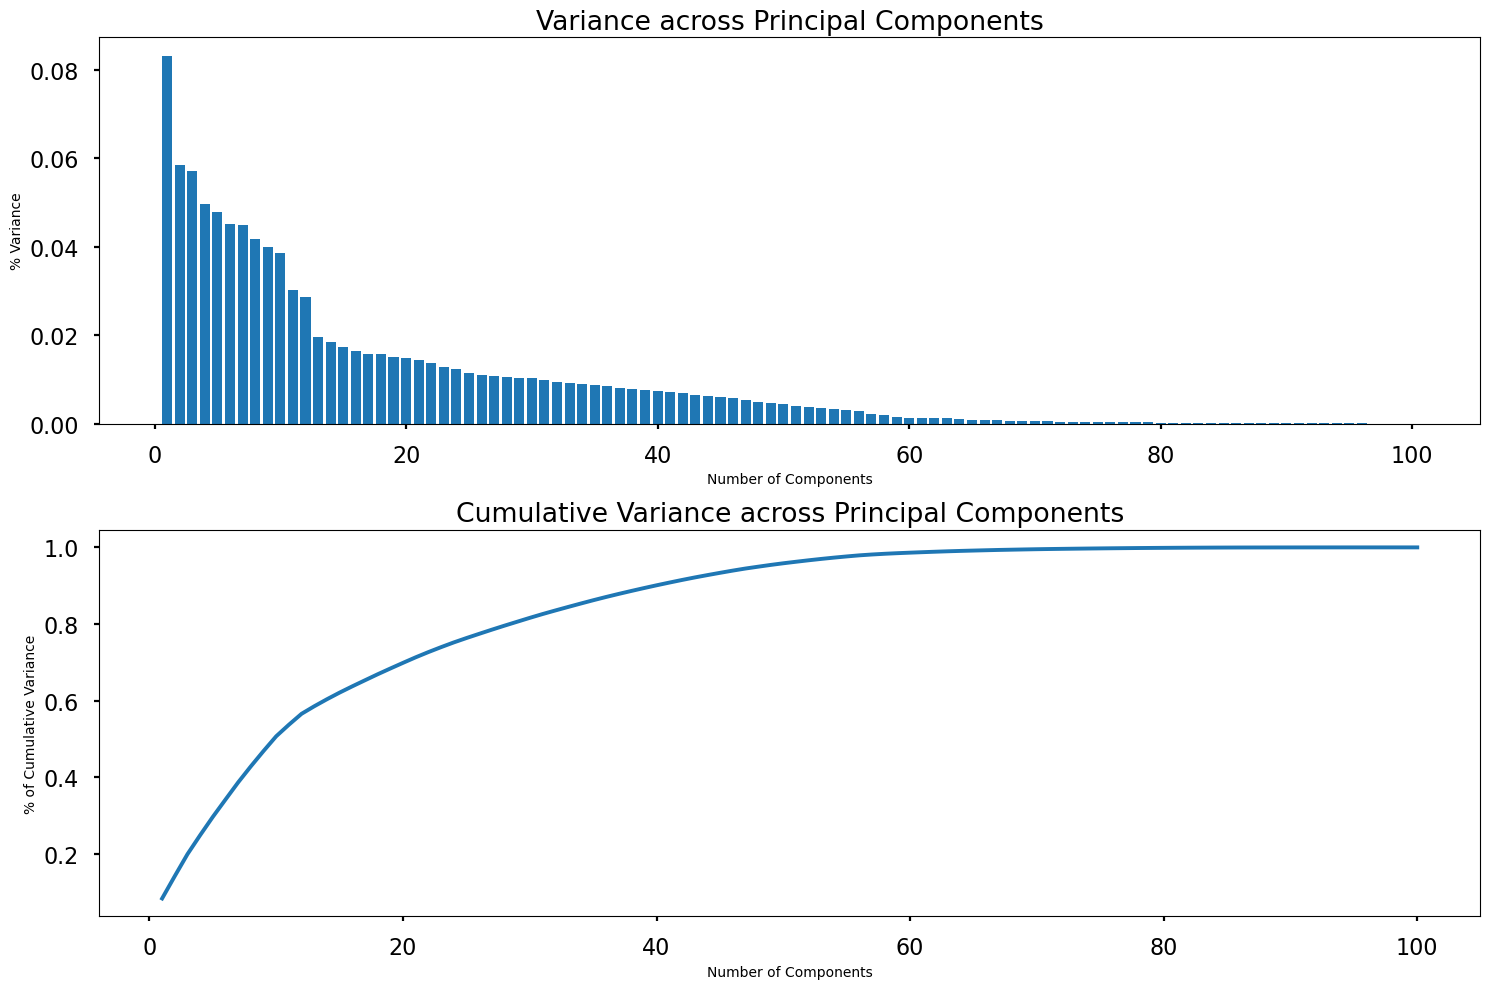

In [58]:
# plot the explained variance across each component

num_vars_list = list(range(1,101))
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.bar(num_vars_list,explained_variance)
plt.title("Variance across Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("% Variance")
plt.tight_layout()

# plot the cumulative one 
plt.subplot(2,1,2)
plt.plot(num_vars_list,explained_variance_cumulative)
plt.title("Cumulative Variance across Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("% of Cumulative Variance")
plt.tight_layout()
plt.show()

#### As we said in tutorial, the first component describes the maximum variance, followed by each subsequent componenets which explains less & less

From the above plots, there is'nt any indication of exactly how many components we should be using and like K-Means
there is'nt really right or wrong answer. It is a trade off between number of components that you are happy dealing with and the amount of variance you want to be explained

Looking at cumulative chart, 75% of variance is explained around 20 or 25 components. so as a starter i might try that

In [59]:
# Apply PCA with selected number of components

pca = PCA(n_components=0.75, random_state=42)

In [60]:
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [61]:
print(X_train.shape)
print(X_test.shape)
# we can see we have 24 columns now reduced from 100
# this means the number of components needed for 75% of variance was 24
# that is a pretty big reduction from original 100 that we have


(284, 24)
(72, 24)


In [63]:
X_train

array([[-0.4021941 , -0.75699883,  0.21924717, ...,  0.69928552,
        -0.05906372,  0.76055747],
       [-0.36007213, -1.13108387,  0.40324893, ...,  0.11438061,
        -0.07724435,  0.02465604],
       [10.69293403, -0.86657383,  0.71198676, ..., -1.10447554,
         2.30523994,  2.60770229],
       ...,
       [ 1.00197218, -1.66885784,  0.63427027, ..., -3.40318488,
         0.87659913, -2.01704601],
       [-0.75303097,  3.75845543, -3.87202645, ...,  1.05689123,
        -0.96292728,  0.42868757],
       [-0.48844855, -0.58581165,  0.03826661, ...,  1.41959942,
         0.08132504,  0.32049442]])


Here, column “0” represents the first component, column “1” represents the second component, and so on. This are the input variables we will feed into our classification model to predict which customers purchased Ed Sheeran’s last album!

In [64]:
# we could have found this number using n_components attribute of our PCA object
pca.n_components_ # we also get provided value 24

24

In [65]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [66]:
y_pred_class = clf.predict(X_test)
print(accuracy_score(y_test,y_pred_class))

0.9305555555555556


#### so we can see 93% of accuracy based on 24 of 100 variables. all thanks to PCA
Now we can confidently go back to ABC Grocery and suggest they get up to-date listening data , so that we can apply the model to predict which customers are highly likely to be interested in edsheeran's new album